## 1. Data Loading and Spliting

In this section, we load the final feature-selected and preprocessed dataset from train_dataset_selected.csv. We split the data into feature matrix X and target labels y, and then divide the dataset into training and testing subsets using an 80/20 ratio. The stratify=y parameter ensures that both classes (porphyry vs. non-porphyry) are proportionally represented in the split, preventing imbalance-related bias during evaluation.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load selected and preprocessed dataset
df = pd.read_csv("../../data/processed/train_dataset_selected.csv")

# Separate features and labels
X = df.drop(columns=["label"])
y = df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 2. Random Forest Model Definition and Training

we define and train a Random Forest classifier as our first non-linear baseline model after logistic regression. 

We use 200 estimators with a maximum depth of 10 to limit tree complexity. Additionally, we apply class_weight='balanced' to account for potential class imbalance in the dataset. After model fitting, we use the trained model to generate predictions and class probabilities on the test set, which will be evaluated in the next stage.

In [3]:
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)

# Fit the model
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

## 3. Model Evaluation and Metrics

Once the model is trained, we evaluate its performance on the test set using a combination of quantitative metrics and visualizations. 

The classification report provides key metrics such as precision, recall, and F1-score for both classes. Particular attention is paid to recall for class 1 (porphyry), which indicates the model’s effectiveness at identifying potential mineralized zones. 

The confusion matrix helps visualize correct vs. incorrect predictions, offering insights into false positives and false negatives. We also compute the ROC curve and AUC score to assess the model’s ability to distinguish between the two classes across all thresholds. A higher AUC indicates strong discriminative capability and robust overall performance.

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       380
           1       0.86      0.92      0.89       190

    accuracy                           0.92       570
   macro avg       0.91      0.92      0.91       570
weighted avg       0.93      0.92      0.92       570



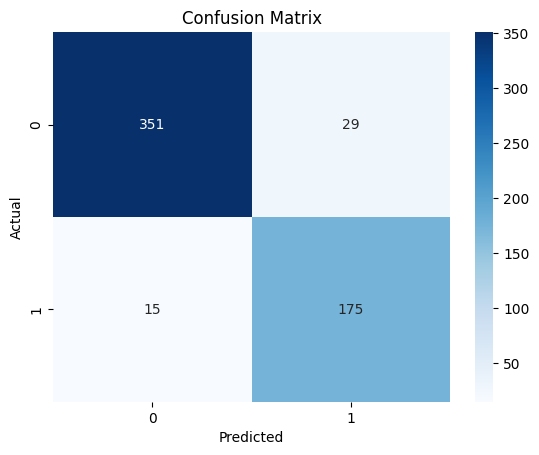

ROC AUC: 0.971


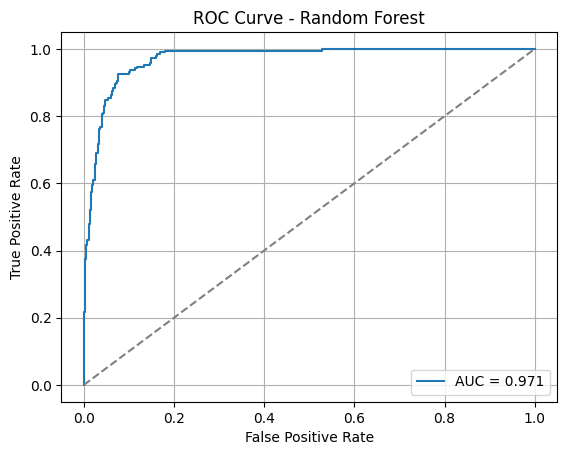

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.3f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()


## 4. Feature Importance Analysis

we analyze the feature importance scores computed by the Random Forest. These scores indicate how much each feature contributes to the model’s decision-making process. Features are ranked based on their relative importance, and the top contributors are visualized to provide insight into what variables drive model predictions.

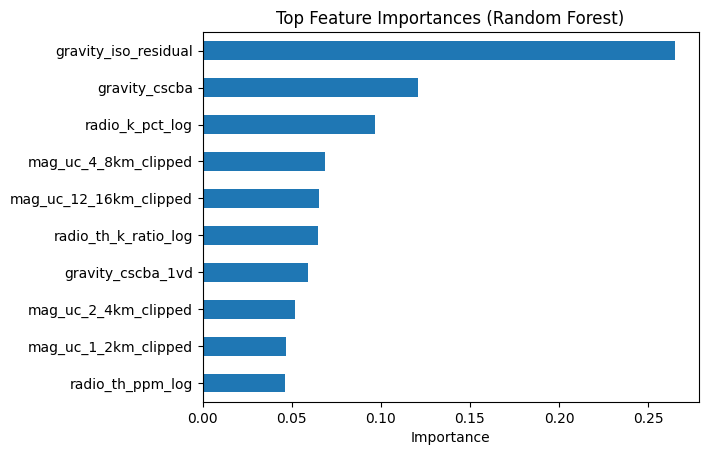

In [5]:
# Show top features
import numpy as np

feat_importance = pd.Series(rf.feature_importances_, index=X.columns)
feat_importance.sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


## 5. Hyperparameter Tuning

To further improve model performance, we perform hyperparameter tuning using GridSearchCV. We define a search space for parameters such as n_estimators, max_depth, and min_samples_split. The grid search runs a cross-validated evaluation over all parameter combinations and selects the one that yields the best Recall score. This tuning process enhances the model’s generalization ability and reduces the risk of overfitting or underfitting due to suboptimal configuration. The best model can be retrieved using grid.best_estimator_, which can then be retrained or directly used for final predictions.

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 15],
    'min_samples_split': [2, 5, 10]
}

scoring = {
    'AUC': 'roc_auc',
    'Recall': 'recall',
    'Precision': 'precision',
    'F1': 'f1'
}


grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [12]:
best_rf = grid.best_estimator_
best_rf.fit(X_train, y_train)
# Predict
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       380
           1       0.82      0.90      0.86       190

    accuracy                           0.90       570
   macro avg       0.88      0.90      0.89       570
weighted avg       0.91      0.90      0.90       570



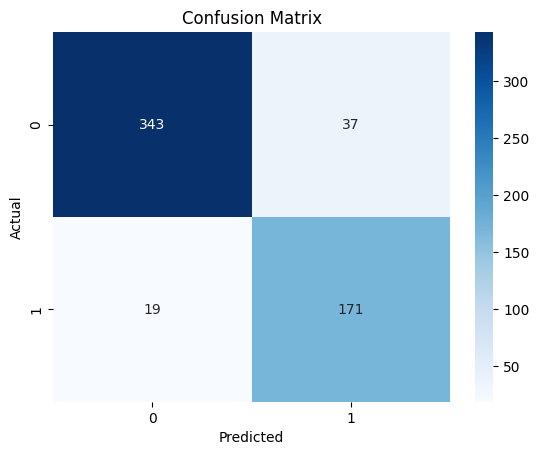

ROC AUC: 0.968


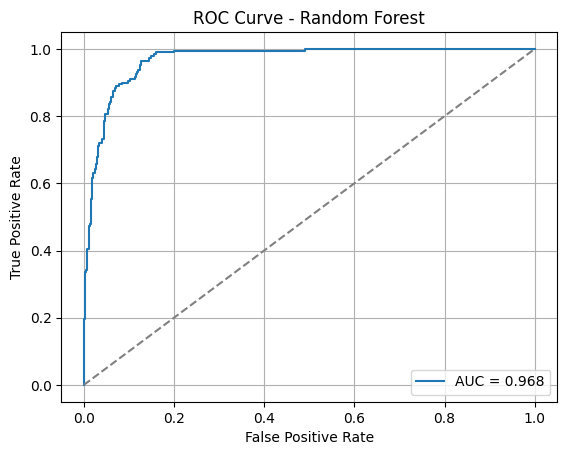

In [13]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.3f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import joblib
joblib.dump(best_rf, "../../models/rf_model.pkl")

['../../models/rf_model.pkl']